In [2]:
import os
from random import randint
import pandas as pd
import numpy as np
import csv
import glob
import re
import cantera as ct
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.image as mpimg
%matplotlib inline

plt.style.use('seaborn-white')
from pathlib import Path
import time

import matplotlib.cm as cm
from IPython.display import Image

import sys
prefix = '/work/westgroup/ChrisB/_01_MeOH_repos'
sys.path.append( 
    f'{prefix}/uncertainty_analysis/uncertainty_cantera/Spinning_basket_reactor'
)
from sbr import MinSBR
import yaml

In [45]:
unc_folder = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/"
conda_path = unc_folder + "conda/"
RMG_base_folder = unc_folder + "RMG-Py/"
RMG_db_folder = unc_folder + "RMG-database/"
conda_path = unc_folder + "conda/"
expt_yaml_file = ""
output_path  = "/scratch/blais.ch/methanol_results_2022_05_09/"

In [46]:
# obj_func_filename = "objective_function_log_ct_analysis_artol.txt"
obj_func_filename = "objective_function_log2.txt"

obj_func_files = glob.glob(os.path.join(output_path,f"run_*/cantera/{obj_func_filename}"))

obj_func_dict = {}
model_size_dict = {}
pattern = re.compile('run_+\d')
for file in obj_func_files:
    with open(file, "r") as f:
        line = f.readline()
        path,obj_func = line.split(":")
        
        # find the string for the run number 
        pattern = re.compile('run_\d{4}')
        match = re.search('run_\d{4}',file)
        run_num = int(match.group(0).replace('run_', ""))
        
        obj_func_dict[run_num] = float(obj_func)
        
    # access log file to get number fo species    
    new_addr = file.replace(f"cantera/{obj_func_filename}", "RMG.log")
    with open(new_addr, "r") as f:
        for line in f.readlines():
            if re.search('The final model core has', line, re.I):
                match_spec = re.search('[0-9]+ species',line)
                spec_num = int(match_spec.group(0).replace(" species", ""))
                
                match_reac = re.search('[0-9]+ reactions',line)
                reac_num = int(match_reac.group(0).replace(" reactions", ""))

                model_size_dict[run_num] = (spec_num,reac_num)
                
low_obj_func_dict = {}
low_model_size_dict = {}
for key, value in obj_func_dict.items(): 
    if value <= 1000.0 and value >= -1000.0:# or value >= 294:
        low_obj_func_dict[key] = value
        low_model_size_dict[key] = model_size_dict[key]


closest = min(obj_func_dict, key=lambda y: abs(obj_func_dict[y]))
print(closest,obj_func_dict[closest])

run_num = str(closest).zfill(4)
model_path =  os.path.join(output_path,f"run_{run_num}")
csv_path = os.path.join(model_path, "cantera/ct_analysis.csv")
data_graaf = pd.read_csv(csv_path)
data_graaf = data_graaf[data_graaf["use_for_opt"] == True]

3171 27.677718974404243


In [47]:
model_path

'/scratch/blais.ch/methanol_results_2022_05_09/run_3171'

# prettydot function

In [48]:
def prettydot(species_path="", dotfilepath="", strip_line_labels=False):
        """
        Make a prettier version of the dot file (flux diagram)

        Assumes the species pictures are stored in a directory
        called 'species_pictures' alongside the dot file.
        """
        pictures_directory = f'{species_path}/'

        if strip_line_labels:
            print("stripping edge (line) labels")

        reSize = re.compile('size="5,6"\;page="5,6"')
        reNode = re.compile(
            '(?P<node>s\d+)\ \[\ fontname="Helvetica",\ label="(?P<label>[^"]*)"\]\;'
        )

        rePicture = re.compile("(?P<smiles>.+?)\((?P<id>\d+)\)\.png")
        reLabel = re.compile("(?P<name>.+?)\((?P<id>\d+)\)$")

        species_pictures = dict()
        for picturefile in os.listdir(pictures_directory):
            match = rePicture.match(picturefile)
            if match:
                species_pictures[match.group("id")] = picturefile
            else:
                pass
                # print(picturefile, "didn't look like a picture")

        filepath = dotfilepath

        if not open(filepath).readline().startswith("digraph"):
            raise ValueError("{0} - not a digraph".format(filepath))

        infile = open(filepath)
        prettypath = filepath.replace(".dot", "", 1) + "-pretty.dot"
        outfile = open(prettypath, "w")

        for line in infile:
            (line, changed_size) = reSize.subn('size="12,12";page="12,12"', line)
            match = reNode.search(line)
            if match:
                label = match.group("label")
                idmatch = reLabel.match(label)
                if idmatch:
                    idnumber = idmatch.group("id")
                    if idnumber in species_pictures:
                        line = (
                            f'%s [ image="{pictures_directory}%s" label="" width="0.1" height="0.1" imagescale=false fixedsize=false color="none" ];\n'
                            % (match.group("node"), species_pictures[idnumber])
                        )

            # rankdir="LR" to make graph go left>right instead of top>bottom
            if strip_line_labels:
                line = re.sub('label\s*=\s*"\s*[\d.]+"', 'label=""', line)

            # change colours
            line = re.sub('color="0.7,\ (.*?),\ 0.9"', r'color="1.0, \1, 0.7*\1"', line)

            outfile.write(line)

        outfile.close()
        infile.close()
        print(f"Graph saved to: {prettypath}")
        os.system(f'dot {prettypath} -Tpng -o{prettypath.replace(".dot", "", 1) + ".png"} -Gdpi=300')
        return prettypath

# best fit model

In [49]:
cti_file_path = f'{model_path}/cantera/chem_annotated.cti'
rmg_model_folder = os.path.dirname(cti_file_path)
csv_path = os.path.join(rmg_model_folder, "ct_analysis.csv")

# generate settings array
settings_yaml = f'{prefix}/uncertainty_analysis/uncertainty_cantera/all_experiments_reorg_sbr.yaml'
with open(settings_yaml, 'r') as f:
    settings = yaml.safe_load(f)

sbr_ss = MinSBR(
    cti_file_path,
    reac_config = settings[100],
    rtol=1.0e-11,
    atol=1.0e-22,
)

In [50]:
for i,name in enumerate(sbr_ss.gas.species_names):
    print(name, ":", sbr_ss.r.kinetics.net_production_rates[i])

N2 : 0.0
Ne : 0.0
H2(2) : -1.1993389988797813e-24
CO(3) : -9.596761500395546e-28
CO2(4) : -1.1983793227297419e-24
H2O(5) : 0.0
CH2O(6) : 9.596761500395546e-28
HCOOH(7) : 1.1983793227297419e-24
CH3OH(8) : 0.0
HCOOCH3(9) : 0.0
CH4(24) : 0.0
C2H4O(72) : 0.0
C2H4O2(73) : 0.0
OCCO(126) : 0.0
CCO(170) : 0.0


In [51]:
spec_name_list = sbr_ss.gas.species_names+sbr_ss.surf.species_names
for i,name in enumerate(spec_name_list):
    print(name, ":", sbr_ss.rsurf.kinetics.net_production_rates[i])

N2 : 0.0
Ne : 0.0
H2(2) : -5.589536792394235
CO(3) : -3.2730799225369407
CO2(4) : -0.03968119713284539
H2O(5) : 0.0
CH2O(6) : 0.0
HCOOH(7) : 0.0
CH3OH(8) : 0.0
HCOOCH3(9) : 0.0
CH4(24) : 0.0
C2H4O(72) : 0.0
C2H4O2(73) : 0.0
OCCO(126) : 0.0
CCO(170) : 0.0
X(1) : -14.491834704458515
H*(10) : 11.17907358478847
O*(11) : 2.575592656097287e-13
OH*(12) : 0.0
H2O*(13) : 0.0
CO*(14) : 3.2730799225371983
CO2*(15) : 0.03968119713258783
HCO*(16) : 0.0
HCOO*(17) : 0.0
COOH*(18) : 0.0
HCOOH*(19) : 0.0
CH2O*(20) : 0.0
CH3O*(21) : 0.0
CH3O2*(22) : 0.0
CH3OH*(23) : 0.0
CH3X(35) : 0.0
CH3OX(49) : 0.0
SX(59) : 0.0
SX(62) : 0.0
SX(77) : 0.0
SX(78) : 0.0
C2H3OX(99) : 0.0
SX(102) : 0.0
SX(104) : 0.0
SX(106) : 0.0
SX(107) : 0.0
SX(110) : 0.0
SX(112) : 0.0
SX(113) : 0.0
SX(114) : 0.0
SX(115) : 0.0
SX(116) : 0.0
SX(117) : 0.0
SX(123) : 0.0
SX(125) : 0.0
SX(129) : 0.0
SX(133) : 0.0
SX(134) : 0.0
SX(153) : 0.0
SX(164) : 0.0


In [52]:
sbr_ss.r.kinetics.net_production_rates

array([ 0.00000000e+00,  0.00000000e+00, -1.19933900e-24, -9.59676150e-28,
       -1.19837932e-24,  0.00000000e+00,  9.59676150e-28,  1.19837932e-24,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [53]:
settings[220]

{'catalyst_area': 44.4241930003398,
 'experiment_type': 'sbr',
 'expt_name': 'grabow2011',
 'output': {'CH3OH': 0.0488, 'H2O': 0.0346},
 'pressure': 7599300,
 'species': {'CO': 0.08, 'CO2': 0.12, 'H2': 0.8, 'H2O': 0.0},
 'temperature': 528,
 'use_for_opt': False,
 'volume': 0.0001346957850226624,
 'volume_flowrate': 7.84e-06}

In [54]:
sbr_ss.run_reactor_ss_memory()

{'experiment': 'graaf_1988',
 'use_for_opt': True,
 'time (s)': 1702.4128975930628,
 'T (K)': 516.7,
 'P (Pa)': 1500000.0,
 'V (m^3/s)': 1.482e-05,
 'x_CO initial': 0.12000000000000001,
 'x_CO2 initial': 0.021,
 'x_H2 initial': 0.8590000000000001,
 'x_H2O initial': 0.0,
 'CO2/(CO2+CO)': 0.14893617021276598,
 '(CO+CO2/H2)': 0.16414435389988358,
 'T (K) final': 516.7,
 'Rtol': 1e-11,
 'Atol': 1e-22,
 'reactor type': 'IdealGasReactor',
 'energy on?': 'off',
 'catalyst area': 44.424193000339805,
 'graaf MeOH TOF 1/s': 0.003754807043371358,
 'graaf H2O TOF 1/s': 0.00041720078259681754,
 'RMG MeOH TOF 1/s': 0.0006427143977691469,
 'RMG H2O TOF 1/s': 0.0011727344452553729,
 'error squared MeOH TOF': 0.6869573693734079,
 'error squared H2O TOF': 3.2795738071789664,
 'obj_func': 3.9665311765523743,
 'log10(RMG/graaf) MeOH TOF': -0.7665695949872939,
 'log10(RMG/graaf) H2O TOF': 0.4488545669084808,
 'log10(RMG/graaf) TOF': -0.15885751403940657,
 'N2': 0.0,
 'Ne': 0.0,
 'H2(2)': 0.8557764692304785

In [55]:
sbr_ss.r.kinetics.net_production_rates

array([ 0.00000000e+00,  0.00000000e+00, -9.98723527e-25, -3.28320803e-21,
        1.08294241e-17, -2.54965457e-21,  9.33665331e-28,  2.55065236e-21,
       -7.33552577e-22, -1.08286915e-17,  1.08294251e-17, -5.29200381e-29,
       -4.51947781e-26,  0.00000000e+00,  0.00000000e+00])

In [56]:
for num, spec in enumerate(sbr_ss.gas.species_names):
    print(spec, ":", sbr_ss.gas[spec].X)

N2 : [0.]
Ne : [0.]
H2(2) : [0.85577647]
CO(3) : [0.11932361]
CO2(4) : [0.01981763]
H2O(5) : [0.00250115]
CH2O(6) : [3.68175555e-08]
HCOOH(7) : [7.99925817e-09]
CH3OH(8) : [0.00137098]
HCOOCH3(9) : [3.09108289e-08]
CH4(24) : [0.00120249]
C2H4O(72) : [5.63687019e-08]
C2H4O2(73) : [2.62928831e-09]
OCCO(126) : [3.24674152e-08]
CCO(170) : [7.51263156e-06]


In [57]:
for num, spec in enumerate(sbr_ss.surf.species_names):
    print(spec, ":", sbr_ss.surf[spec].X)

X(1) : [0.96338972]
H*(10) : [0.0004399]
O*(11) : [1.22742081e-10]
OH*(12) : [1.57399779e-13]
H2O*(13) : [0.00636139]
CO*(14) : [0.00042234]
CO2*(15) : [8.41368688e-05]
HCO*(16) : [7.57160753e-08]
HCOO*(17) : [1.01932052e-11]
COOH*(18) : [4.42384567e-14]
HCOOH*(19) : [1.39693455e-12]
CH2O*(20) : [0.00056551]
CH3O*(21) : [1.95827831e-10]
CH3O2*(22) : [2.63870597e-16]
CH3OH*(23) : [0.02845111]
CH3X(35) : [2.29111248e-11]
CH3OX(49) : [1.39201481e-07]
SX(59) : [1.16147678e-13]
SX(62) : [1.05623079e-06]
SX(77) : [1.59616926e-20]
SX(78) : [1.15400142e-15]
C2H3OX(99) : [3.45760993e-08]
SX(102) : [5.40569443e-14]
SX(104) : [1.47526305e-14]
SX(106) : [4.33587999e-15]
SX(107) : [2.57174445e-05]
SX(110) : [1.00143593e-10]
SX(112) : [1.19920477e-06]
SX(113) : [3.1161217e-16]
SX(114) : [1.84185337e-12]
SX(115) : [3.27708082e-15]
SX(116) : [4.36582889e-17]
SX(117) : [3.50192308e-16]
SX(123) : [0.00025656]
SX(125) : [1.10867628e-06]
SX(129) : [6.00520466e-13]
SX(133) : [7.83627074e-13]
SX(134) : [4.6

In [58]:
x = dict(zip(sbr_ss.surf.reaction_equations(), sbr_ss.rsurf.kinetics.forward_rates_of_progress))

y = dict(sorted(x.items(), key=lambda kv: kv[-1]))
import collections

sorted_rate = collections.OrderedDict(y)

for equ, rate in sorted_rate.items():
    print(equ, ":", rate )

HCOOH*(19) + SX(77) <=> COOH*(18) + SX(110) : 9.750218267314109e-40
HCOOH*(19) + SX(77) <=> HCOO*(17) + SX(110) : 1.0581404358252589e-39
HCOOH*(19) + SX(153) <=> COOH*(18) + SX(112) : 7.70200707096627e-39
HCOOH*(19) + SX(153) <=> HCOO*(17) + SX(112) : 8.358587362215531e-39
OH*(12) + SX(106) <=> O*(11) + SX(77) : 9.377514129866884e-39
2 SX(133) <=> SX(106) + SX(110) : 1.9596124611077374e-38
2 SX(77) <=> SX(106) + SX(110) : 3.717317297027818e-38
SX(133) + SX(77) <=> SX(106) + SX(110) : 3.818795413578571e-38
SX(102) + SX(133) <=> SX(106) + SX(110) : 4.2275608299802403e-38
SX(110) + SX(77) <=> SX(102) + SX(110) : 7.253273941581623e-38
HCOO*(17) + SX(133) <=> HCOOH*(19) + SX(106) : 8.05388007075067e-38
SX(102) + SX(77) <=> SX(106) + SX(110) : 8.230440909007056e-38
SX(110) + SX(77) <=> SX(110) + SX(133) : 1.5009554932236258e-37
HCOO*(17) + SX(77) <=> HCOOH*(19) + SX(106) : 1.5695001377113457e-37
HCOOH*(19) + SX(134) <=> HCO*(16) + SX(110) : 2.7154448297719125e-37
HCOOH*(19) + OH*(12) <=> CH3

SX(112) + X(1) <=> CH3X(35) + COOH*(18) : 1.51327325151614e-20
OH*(12) + SX(133) <=> H2O*(13) + SX(106) : 2.6126064859408954e-20
CH3O*(21) + SX(78) <=> CH3OH*(23) + SX(62) : 2.8192831979596174e-20
CH3OX(49) + HCOO*(17) <=> CH3OH*(23) + CO2*(15) : 3.3866733787797245e-20
CO*(14) + H2O*(13) <=> HCO*(16) + OH*(12) : 4.423771111406975e-20
CH3O*(21) + OH*(12) <=> CH2O*(20) + H2O*(13) : 4.7108146361080766e-20
OH*(12) + SX(129) <=> H2O*(13) + SX(110) : 4.8383550262978323e-20
2 CH3O*(21) <=> CH2O*(20) + CH3OH*(23) : 6.544243326530154e-20
CH3O*(21) + CH3OX(49) <=> CH2O*(20) + CH3OH*(23) : 7.732408169171841e-20
HCO*(16) + SX(107) <=> C2H3OX(99) + CH2O*(20) : 8.269634695504124e-20
CH3OH*(23) + CH3X(35) <=> H*(10) + SX(123) : 8.626465759892065e-20
CH3OX(49) + SX(78) <=> CH3OH*(23) + SX(62) : 9.993446458234232e-20
SX(106) + X(1) <=> 2 HCO*(16) : 1.462588286774516e-19
CH3OX(49) + SX(107) <=> HCO*(16) + SX(123) : 1.5412162640706691e-19
CO*(14) + OH*(12) <=> CO2*(15) + H*(10) : 1.5658637430701529e-19
C

H2(2) + 2 X(1) <=> 2 H*(10) : 5.168291650067131


In [59]:
for num, rate in enumerate(sbr_ss.r.kinetics.net_rates_of_progress):
    print(sbr_ss.gas.reaction_equations()[num], ":", rate )

CO(3) + H2(2) <=> CH2O(6) : 9.336653309106457e-28
CO(3) + H2O(5) <=> HCOOH(7) : 2.5496545727594465e-21
CO2(4) + H2(2) <=> HCOOH(7) : 3.325966204825073e-25
CH3OH(8) + CO(3) <=> HCOOCH3(9) : 7.335525773174419e-22
CH4(24) + CO2(4) <=> HCOOCH3(9) : -1.0829425068341073e-17
CO2(4) + H2(2) <=> HCOOH(7) : 3.325966204825073e-25
CO2(4) + H2(2) <=> HCOOH(7) : 3.325966204825073e-25
CH4(24) + CO(3) <=> C2H4O(72) : -5.292003806647681e-29
CH4(24) + CO2(4) <=> C2H4O2(73) : -4.519477805381857e-26


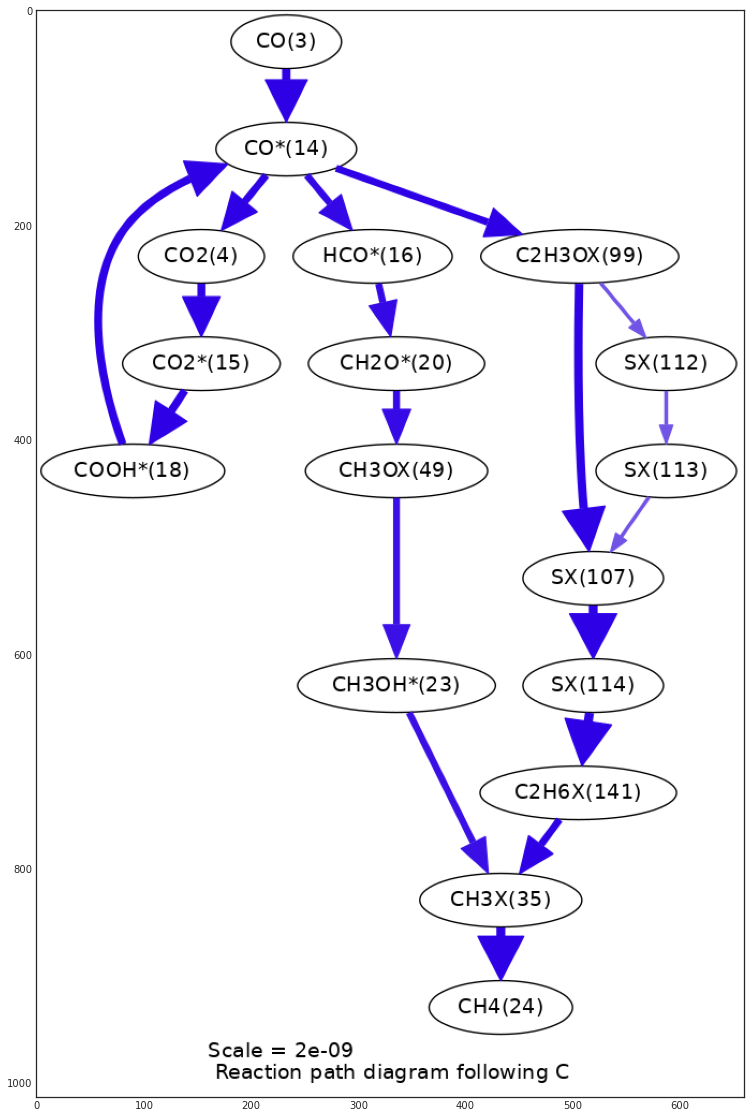

In [124]:
element = 'C'
diagram = ct.ReactionPathDiagram(sbr_ss.surf, element)
diagram.title = 'Reaction path diagram following {0}'.format(element)
diagram.scale=-1
diagram.threshold = 0.10
diagram.label_threshold = 1e5

dot_file = 'rxnpath.dot'
img_file = 'rxnpath.png'
img_path = Path.cwd().joinpath(img_file)

diagram.write_dot(dot_file)
os.system(f"dot {dot_file} -Tpng -o{img_path} -Gdpi=100")
plt.figure(figsize = (20,20))
image = mpimg.imread(img_path)
plt.imshow(image,aspect='equal')
plt.show()

Graph saved to: rxnpath-pretty.dot


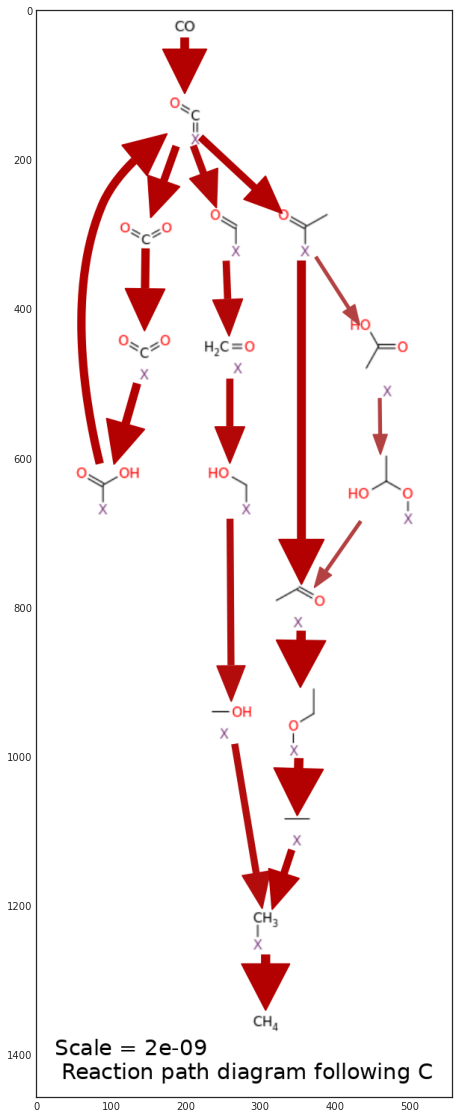

In [125]:
species_path = rmg_model_folder.replace("cantera", "species")
pretty_dot_path = prettydot(species_path=species_path, dotfilepath=dot_file)
img_path = pretty_dot_path.replace(".dot", ".png")
os.system(f"dot {pretty_dot_path} -Tpng -o{img_path} -Gdpi=150")
plt.figure(figsize = (10,20))
image = mpimg.imread(img_path)
plt.imshow(image,aspect='equal')
plt.show()

In [16]:
for num, spec in enumerate(sbr_ss.gas.species_names):
    print(spec, ":", sbr_ss.gas[spec].X)

N2 : [0.]
Ar : [0.]
He : [0.]
Ne : [0.]
H2(2) : [0.43031397]
CO(3) : [1.16694152e-05]
CO2(4) : [0.06956109]
H2O(5) : [0.28987238]
CH2O(6) : [2.80732341e-13]
HCOOH(7) : [1.80512781e-07]
CH3OH(8) : [2.26865617e-09]
HCOOCH3(9) : [2.50154091e-17]
CH4(24) : [0.21020567]
C2H4O(67) : [4.24848887e-12]
C2H4O2(68) : [2.21707581e-11]
CC(131) : [3.50334952e-05]
CCO(137) : [6.09717344e-13]
S(177) : [9.21176626e-16]


In [17]:
for num, spec in enumerate(sbr_ss.surf.species_names):
    print(spec, ":", sbr_ss.surf[spec].X)

X(1) : [0.9528275]
H*(10) : [0.02742341]
O*(11) : [6.34026835e-08]
OH*(12) : [8.69603443e-12]
H2O*(13) : [0.0195099]
CO*(14) : [5.97444013e-05]
CO2*(15) : [6.32609113e-06]
HCO*(16) : [4.65812423e-09]
HCOO*(17) : [2.44375547e-11]
COOH*(18) : [9.19480625e-11]
HCOOH*(19) : [8.41925435e-13]
CH2O*(20) : [8.25281819e-11]
CH3O*(21) : [1.14520532e-15]
CH3O2*(22) : [4.57792142e-19]
CH3OH*(23) : [1.47032765e-09]
CH3X(28) : [1.08442782e-10]
CH3OX(44) : [2.39073463e-10]
CH2OX(52) : [2.42399705e-19]
SX(54) : [8.36838481e-20]
SX(57) : [2.68706155e-17]
SX(72) : [8.29106521e-30]
SX(73) : [1.05486437e-25]
CHOX(76) : [1.71138493e-18]
C2HO2X(93) : [1.95558419e-20]
C2H3OX(95) : [4.80764156e-09]
SX(98) : [8.19917308e-17]
SX(100) : [1.20276391e-17]
SX(103) : [4.7989228e-11]
SX(108) : [2.42157569e-10]
SX(109) : [1.11335348e-18]
SX(110) : [1.03330686e-19]
SX(111) : [3.26363524e-19]
SX(120) : [2.0627477e-19]
C2H6X(127) : [0.00017304]
SX(129) : [6.68755328e-13]
SX(141) : [4.86931018e-20]
SX(147) : [1.31069931e-

In [20]:
prefix = '/Users/blais.ch/_01_code/05_Project_repos_Github/meOH_repos/'
# load file paths
rmg_model_path = f"{prefix}/meOH-synthesis/"

cantera_path = rmg_model_path + "base/cantera/"

data_all = pd.read_csv(cantera_path+ "ct_analysis.csv")
data_graaf = data_all[data_all['experiment'] == "graaf_1988"]
data_grab = data_all[data_all['experiment'] == "grabow2011"]

df_parity = data_graaf[data_graaf["use_for_opt"] == True]

In [19]:
df_parity

,Unnamed: 0,experiment,use_for_opt,time (s),T (K),P (Pa),V (m^3/s),x_CO initial,x_CO2 initial,x_H2 initial,...,CHOX2(64) + HCOOH*(19) <=> CH2OX2(55) + HCOO*(17) ROP [kmol/m^2 s],CHOX2(64) + HCOOH*(19) <=> CH2OX2(55) + COOH*(18) ROP [kmol/m^2 s],CH2OX2(55) + HCOOH*(19) <=> CH3O2*(22) + CHOX2(64) ROP [kmol/m^2 s],CH2O*(20) + CH2OX2(55) <=> CH3O*(21) + CHOX2(64) ROP [kmol/m^2 s],CH3OH*(23) + CHOX2(64) <=> CH2OX2(55) + CH3O*(21) ROP [kmol/m^2 s],CO(3) + H2(2) <=> CH2O(6) ROP [kmol/m^3 s],CO(3) + H2O(5) <=> HCOOH(7) ROP [kmol/m^3 s],CO2(4) + H2(2) <=> HCOOH(7) ROP [kmol/m^3 s],CH3OH(8) + CO(3) <=> HCOOCH3(9) ROP [kmol/m^3 s],CH4(24) + CO2(4) <=> HCOOCH3(9) ROP [kmol/m^3 s]
0,0,graaf_1988,True,5514.178179,483.5,1530000.0,0.000006,0.065,0.261,0.674,...,-5.932729e-39,-5.740502e-39,1.684449e-25,-1.070424e-20,6.311547e-29,5.576216e-36,-4.536857e-24,2.754213e-30,-6.071272e-29,-4.788512e-16
2,2,graaf_1988,True,10196.933673,483.5,3000000.0,0.000006,0.065,0.261,0.674,...,-1.356631e-38,-1.302810e-38,6.559479e-25,-2.935080e-20,2.394330e-28,1.003641e-35,-1.049632e-23,9.018595e-30,-8.924688e-29,-1.620789e-15
3,3,graaf_1988,True,4482.683268,483.5,3000000.0,0.000014,0.065,0.261,0.674,...,-3.124122e-38,-2.997967e-38,1.532120e-24,-6.900240e-20,5.632623e-28,2.363266e-35,-2.449482e-23,2.122466e-29,-2.088673e-28,-1.604389e-15
6,6,graaf_1988,True,5099.154835,499.3,1500000.0,0.000008,0.065,0.261,0.674,...,-3.392573e-38,-3.269580e-38,2.837709e-25,-1.364949e-20,9.309664e-29,9.229260e-35,-3.340191e-23,3.122863e-29,-4.730209e-28,-1.812545e-15
7,7,graaf_1988,True,2534.062706,499.3,1500000.0,0.000016,0.065,0.261,0.674,...,-6.265426e-38,-6.036566e-38,5.267457e-25,-2.559401e-20,1.746139e-28,1.733315e-34,-6.200785e-23,5.824965e-29,-8.857458e-28,-1.801274e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,graaf_1988,True,2395.743484,499.3,2980000.0,0.000047,0.092,0.105,0.803,...,-1.509811e-37,-1.442415e-37,2.354664e-24,-2.099525e-19,2.318909e-27,7.263765e-34,-1.235437e-22,1.986262e-28,-3.199512e-27,-9.395674e-15
197,197,graaf_1988,True,22285.272778,499.3,4990000.0,0.000009,0.092,0.105,0.803,...,-5.662386e-38,-5.370266e-38,1.165755e-24,-6.245531e-20,8.876450e-28,1.892672e-34,-4.860706e-23,1.210942e-28,-5.831271e-28,-1.798052e-14
198,198,graaf_1988,True,6758.697049,499.3,4980000.0,0.000018,0.092,0.105,0.803,...,-1.142815e-37,-1.083619e-37,2.358898e-24,-1.269466e-19,1.802755e-27,3.849229e-34,-9.840880e-23,2.451904e-28,-1.186192e-27,-1.789364e-14
199,199,graaf_1988,True,3781.481582,499.3,5000000.0,0.000028,0.092,0.105,0.803,...,-1.799692e-37,-1.705844e-37,3.738644e-24,-2.010144e-19,2.860497e-27,6.097064e-34,-1.558434e-22,3.904988e-28,-1.869150e-27,-1.792291e-14


# baseline model

In [111]:
model_path = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/uncertainty_baseline"
cti_file_path = f'{model_path}/cantera/chem_annotated.cti'
rmg_model_folder = os.path.dirname(cti_file_path)
csv_path = os.path.join(rmg_model_folder, "ct_analysis.csv")

# generate settings array
settings_yaml = f'{prefix}/uncertainty_analysis/uncertainty_cantera/all_experiments_reorg_sbr.yaml'
with open(settings_yaml, 'r') as f:
    settings = yaml.safe_load(f)

sbr_ss = MinSBR(
    cti_file_path,
    reac_config = settings[100],
    rtol=1.0e-11,
    atol=1.0e-22,
)

In [112]:
for i,name in enumerate(sbr_ss.gas.species_names):
    print(name, ":", sbr_ss.r.kinetics.net_production_rates[i])

N2 : 0.0
Ne : 0.0
H2(2) : -1.1993389988797813e-24
CO(3) : -9.596761500395546e-28
CO2(4) : -1.1983793227297419e-24
H2O(5) : 0.0
CH2O(6) : 9.596761500395546e-28
HCOOH(7) : 1.1983793227297419e-24
CH3OH(8) : 0.0
HCOOCH3(9) : 0.0
CH4(24) : 0.0
C2H4O(72) : 0.0
C2H4O2(73) : 0.0
CCO(143) : 0.0
CC(144) : 0.0


In [113]:
spec_name_list = sbr_ss.gas.species_names+sbr_ss.surf.species_names
for i,name in enumerate(spec_name_list):
    print(name, ":", sbr_ss.rsurf.kinetics.net_production_rates[i])

N2 : 0.0
Ne : 0.0
H2(2) : -5.589536792394235
CO(3) : -3.2730799225369407
CO2(4) : -0.00457069226525012
H2O(5) : 0.0
CH2O(6) : 0.0
HCOOH(7) : 0.0
CH3OH(8) : 0.0
HCOOCH3(9) : 0.0
CH4(24) : 0.0
C2H4O(72) : 0.0
C2H4O2(73) : 0.0
CCO(143) : 0.0
CC(144) : 0.0
X(1) : -14.456725276799649
H*(10) : 11.17907358478847
O*(11) : 1.0772089867976797e-06
OH*(12) : 0.0
H2O*(13) : 0.0
CO*(14) : 3.2730809997459276
CO2*(15) : 0.004569615056263322
HCO*(16) : 0.0
HCOO*(17) : 0.0
COOH*(18) : 0.0
HCOOH*(19) : 0.0
CH2O*(20) : 0.0
CH3O*(21) : 0.0
CH3O2*(22) : 0.0
CH3OH*(23) : 0.0
CH3X(35) : 0.0
CH2X(36) : 0.0
CH3OX(49) : 0.0
SX(59) : 0.0
CH4O2X(84) : 0.0
C2H3OX(99) : 0.0
SX(104) : 0.0
SX(107) : 0.0
SX(112) : 0.0
SX(113) : 0.0
SX(114) : 0.0
SX(115) : 0.0
SX(123) : 0.0
SX(136) : 0.0
C2H6X(141) : 0.0
C2H4X(145) : 0.0
SX(148) : 0.0
C2H5X(150) : 0.0
SX(156) : 0.0


In [114]:
sbr_ss.r.kinetics.net_production_rates

array([ 0.00000000e+00,  0.00000000e+00, -1.19933900e-24, -9.59676150e-28,
       -1.19837932e-24,  0.00000000e+00,  9.59676150e-28,  1.19837932e-24,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [115]:
sbr_ss.run_reactor_ss_memory()

{'experiment': 'graaf_1988',
 'use_for_opt': True,
 'time (s)': 1770.344922778919,
 'T (K)': 516.7,
 'P (Pa)': 1499999.999999999,
 'V (m^3/s)': 1.482e-05,
 'x_CO initial': 0.12000000000000001,
 'x_CO2 initial': 0.021,
 'x_H2 initial': 0.8590000000000001,
 'x_H2O initial': 0.0,
 'CO2/(CO2+CO)': 0.14893617021276598,
 '(CO+CO2/H2)': 0.16414435389988358,
 'T (K) final': 516.7,
 'Rtol': 1e-11,
 'Atol': 1e-22,
 'reactor type': 'IdealGasReactor',
 'energy on?': 'off',
 'catalyst area': 44.424193000339805,
 'graaf MeOH TOF 1/s': 0.003754807043371358,
 'graaf H2O TOF 1/s': 0.00041720078259681754,
 'RMG MeOH TOF 1/s': 9.469904091042531e-12,
 'RMG H2O TOF 1/s': 0.07629015024575565,
 'error squared MeOH TOF': 0.9999999949558505,
 'error squared H2O TOF': 33073.770251472306,
 'obj_func': 33074.770251467264,
 'log10(RMG/graaf) MeOH TOF': -8.59824204326288,
 'log10(RMG/graaf) H2O TOF': 2.262123355778478,
 'log10(RMG/graaf) TOF': -3.1680593437422013,
 'N2': 0.0,
 'Ne': 0.0,
 'H2(2)': 0.579130935158471

In [116]:
sbr_ss.r.kinetics.net_production_rates

array([ 0.00000000e+00,  0.00000000e+00, -3.90004548e-27, -4.59103453e-24,
        2.68264474e-25, -4.59103484e-24,  1.66852497e-32,  4.59493487e-24,
        3.33092031e-31, -2.71971827e-25,  2.72164503e-25, -4.59357217e-34,
       -1.93008873e-28,  0.00000000e+00,  0.00000000e+00])

In [117]:
for num, spec in enumerate(sbr_ss.gas.species_names):
    print(spec, ":", sbr_ss.gas[spec].X)

N2 : [0.]
Ne : [0.]
H2(2) : [0.57913094]
CO(3) : [3.41781314e-06]
CO2(4) : [0.00014796]
H2O(5) : [0.22525909]
CH2O(6) : [3.76954298e-12]
HCOOH(7) : [1.11262691e-10]
CH3OH(8) : [2.79825004e-11]
HCOOCH3(9) : [7.76303872e-16]
CH4(24) : [0.19474919]
C2H4O(72) : [5.46435961e-13]
C2H4O2(73) : [1.13402647e-11]
CCO(143) : [1.80609174e-13]
CC(144) : [0.0007094]


In [118]:
for num, spec in enumerate(sbr_ss.surf.species_names):
    print(spec, ":", sbr_ss.surf[spec].X)

X(1) : [0.97093794]
H*(10) : [0.02103397]
O*(11) : [1.28548459e-09]
OH*(12) : [2.70457489e-11]
H2O*(13) : [0.00653988]
CO*(14) : [5.06921118e-06]
CO2*(15) : [7.1695802e-09]
HCO*(16) : [1.43322878e-08]
HCOO*(17) : [2.71141616e-14]
COOH*(18) : [1.11241006e-13]
HCOOH*(19) : [2.57778269e-16]
CH2O*(20) : [6.60883957e-10]
CH3O*(21) : [7.14175681e-15]
CH3O2*(22) : [6.18026962e-19]
CH3OH*(23) : [6.10873139e-12]
CH3X(35) : [1.35742163e-09]
CH2X(36) : [5.00604084e-16]
CH3OX(49) : [4.91171797e-09]
SX(59) : [1.70909147e-18]
CH4O2X(84) : [9.78626632e-15]
C2H3OX(99) : [1.9956771e-09]
SX(104) : [6.40898106e-18]
SX(107) : [2.84561192e-12]
SX(112) : [5.90399805e-11]
SX(113) : [4.19231648e-20]
SX(114) : [4.21685923e-18]
SX(115) : [5.60167499e-17]
SX(123) : [7.0055628e-14]
SX(136) : [4.41059324e-20]
C2H6X(141) : [0.00148311]
C2H4X(145) : [4.88298968e-18]
SX(148) : [1.16195402e-11]
C2H5X(150) : [4.3925485e-13]
SX(156) : [1.91984603e-15]


In [119]:
x = dict(zip(sbr_ss.surf.reaction_equations(), sbr_ss.rsurf.kinetics.forward_rates_of_progress))

y = dict(sorted(x.items(), key=lambda kv: kv[-1]))
import collections

sorted_rate = collections.OrderedDict(y)

for equ, rate in sorted_rate.items():
    print(equ, ":", rate )

SX(113) + SX(114) <=> SX(107) + SX(156) : 1.556685650039348e-43
CH3O2*(22) + SX(114) <=> CH4O2X(84) + SX(107) : 7.1109665318540175e-43
2 SX(113) <=> SX(112) + SX(156) : 2.8348510458336147e-42
CH3O2*(22) + SX(113) <=> HCOOH*(19) + SX(156) : 9.108515867071981e-42
CH3O2*(22) + SX(113) <=> CH4O2X(84) + SX(112) : 1.294964780410529e-41
SX(113) + SX(148) <=> SX(107) + SX(156) : 1.459922465488439e-41
2 CH3O2*(22) <=> CH4O2X(84) + HCOOH*(19) : 4.1607855435664195e-41
CH3O2*(22) + SX(148) <=> CH4O2X(84) + SX(107) : 6.668950658681565e-41
SX(114) + SX(136) <=> SX(107) + SX(112) : 1.6380504214858497e-40
SX(104) + SX(114) <=> SX(107) + SX(112) : 5.065737676851772e-40
HCOO*(17) + SX(114) <=> HCOOH*(19) + SX(107) : 5.395721407675313e-40
CH3OX(49) + SX(113) <=> CH4O2X(84) + SX(107) : 6.312706986110342e-40
SX(113) + SX(136) <=> 2 SX(112) : 2.9830229053373615e-39
SX(104) + SX(113) <=> 2 SX(112) : 9.225119889027707e-39
CH3O2*(22) + SX(136) <=> HCOOH*(19) + SX(112) : 9.593938429872393e-39
HCOO*(17) + SX(113

C2H6X(141) + O*(11) <=> CH3O*(21) + CH3X(35) : 5.302947989300451e-18
CH2O*(20) + CH3X(35) <=> CH2X(36) + CH3OX(49) : 6.329272645555439e-18
C2H4O(72) + 2 X(1) <=> C2H3OX(99) + H*(10) : 6.6674336062150544e-18
C2H5X(150) + SX(112) <=> C2H3OX(99) + SX(123) : 7.18775512894385e-18
C2H5X(150) + SX(112) <=> C2H6X(141) + SX(104) : 7.18775512894385e-18
CH3X(35) + CH4O2X(84) <=> CH3OH*(23) + CH3OX(49) : 7.363635705686824e-18
CH3X(35) + CH4O2X(84) <=> OH*(12) + SX(123) : 7.363635705686824e-18
CH3X(35) + CH4O2X(84) <=> H*(10) + SX(156) : 7.363635705686824e-18
CH3OH*(23) + O*(11) <=> CH3O2*(22) + H*(10) : 7.83977302087715e-18
CO*(14) + SX(112) <=> HCO*(16) + SX(136) : 7.969661361227127e-18
OH*(12) + SX(148) <=> H2O*(13) + SX(107) : 8.627838452749876e-18
SX(107) + SX(148) <=> C2H3OX(99) + SX(123) : 9.164211762648475e-18
HCO*(16) + SX(112) <=> CO*(14) + SX(113) : 9.602052291384167e-18
C2H3OX(99) + CH4O2X(84) <=> CH3OX(49) + SX(112) : 1.0825994522712505e-17
SX(114) <=> SX(115) : 1.0948635447702293e-17


In [120]:
for num, rate in enumerate(sbr_ss.r.kinetics.net_rates_of_progress):
    print(sbr_ss.gas.reaction_equations()[num], ":", rate )

CO(3) + H2(2) <=> CH2O(6) : 1.6685249708460542e-32
CO(3) + H2O(5) <=> HCOOH(7) : 4.591034842705437e-24
CO2(4) + H2(2) <=> HCOOH(7) : 1.300009598676721e-27
CH3OH(8) + CO(3) <=> HCOOCH3(9) : -3.330920309526567e-31
CH4(24) + CO2(4) <=> HCOOCH3(9) : -2.719714938265679e-25
CO2(4) + H2(2) <=> HCOOH(7) : 1.300009598676721e-27
CO2(4) + H2(2) <=> HCOOH(7) : 1.300009598676721e-27
CH4(24) + CO2(4) <=> C2H4O2(73) : -1.9300887333197847e-28
CH4(24) + CO(3) <=> C2H4O(72) : -4.593572172999524e-34


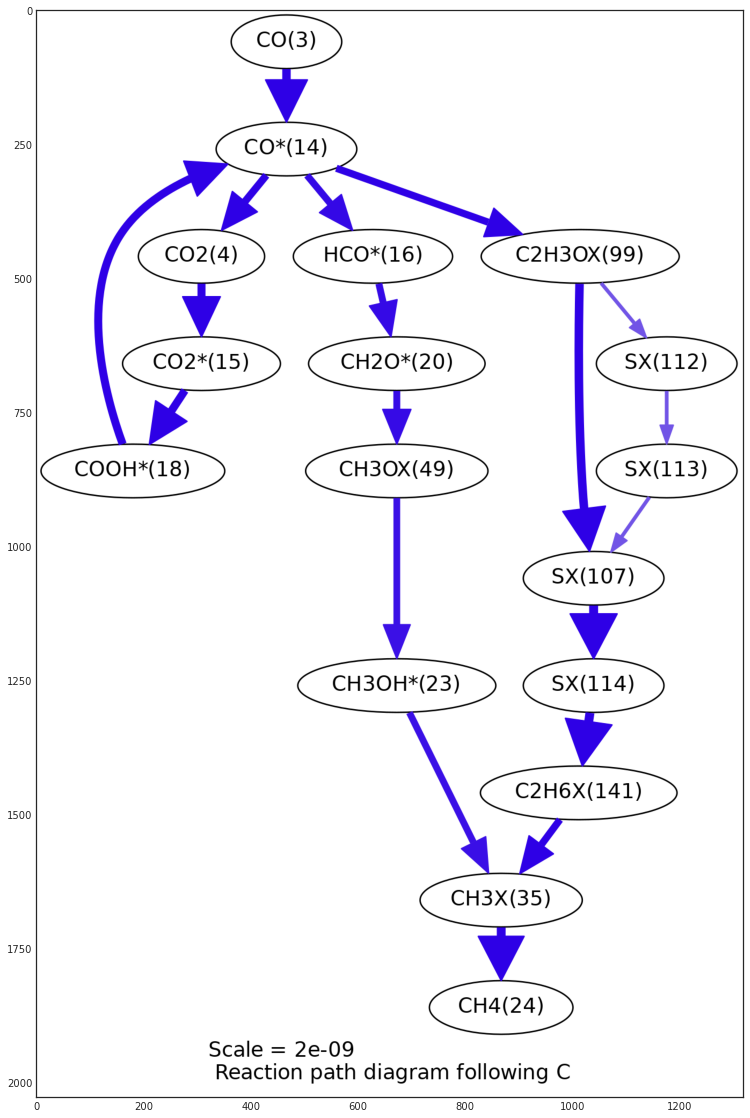

In [122]:
element = 'C'
diagram = ct.ReactionPathDiagram(sbr_ss.surf, element)
diagram.title = 'Reaction path diagram following {0}'.format(element)
diagram.scale=-1
diagram.threshold = 0.10
diagram.label_threshold = 1e5

dot_file = 'rxnpath.dot'
img_file = 'rxnpath.png'
img_path = Path.cwd().joinpath(img_file)

diagram.write_dot(dot_file)
os.system(f"dot {dot_file} -Tpng -o{img_path} -Gdpi=200")
plt.figure(figsize = (20,20))
image = mpimg.imread(img_path)
plt.imshow(image,aspect='equal')
plt.show()

Graph saved to: rxnpath-pretty.dot


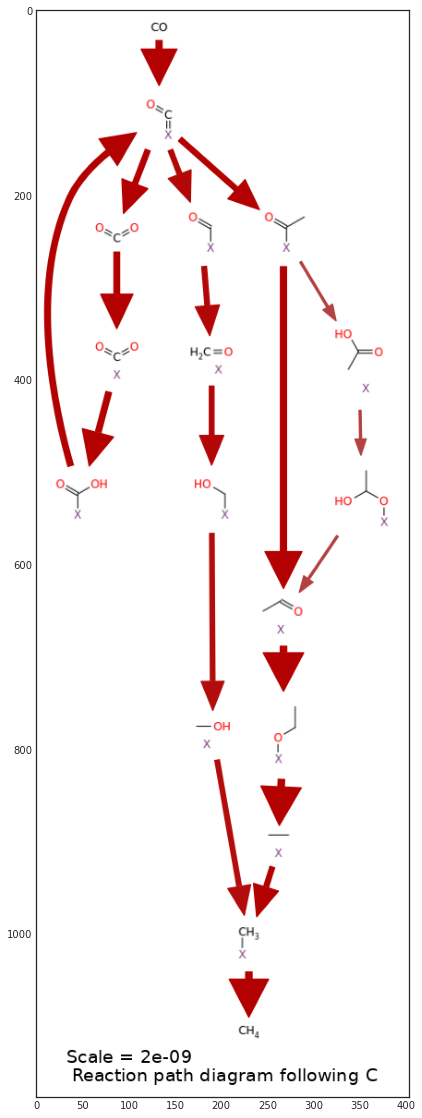

In [123]:
species_path = rmg_model_folder.replace("cantera", "species")
pretty_dot_path = prettydot(species_path=species_path, dotfilepath=dot_file)
img_path = pretty_dot_path.replace(".dot", ".png")
os.system(f"dot {pretty_dot_path} -Tpng -o{img_path} -Gdpi=100")
plt.figure(figsize = (20,20))
image = mpimg.imread(img_path)
plt.imshow(image,aspect='equal')
plt.show()

In [ ]:
rxnpath.dot

In [16]:
for num, spec in enumerate(sbr_ss.gas.species_names):
    print(spec, ":", sbr_ss.gas[spec].X)

N2 : [0.]
Ar : [0.]
He : [0.]
Ne : [0.]
H2(2) : [0.43031397]
CO(3) : [1.16694152e-05]
CO2(4) : [0.06956109]
H2O(5) : [0.28987238]
CH2O(6) : [2.80732341e-13]
HCOOH(7) : [1.80512781e-07]
CH3OH(8) : [2.26865617e-09]
HCOOCH3(9) : [2.50154091e-17]
CH4(24) : [0.21020567]
C2H4O(67) : [4.24848887e-12]
C2H4O2(68) : [2.21707581e-11]
CC(131) : [3.50334952e-05]
CCO(137) : [6.09717344e-13]
S(177) : [9.21176626e-16]


In [17]:
for num, spec in enumerate(sbr_ss.surf.species_names):
    print(spec, ":", sbr_ss.surf[spec].X)

X(1) : [0.9528275]
H*(10) : [0.02742341]
O*(11) : [6.34026835e-08]
OH*(12) : [8.69603443e-12]
H2O*(13) : [0.0195099]
CO*(14) : [5.97444013e-05]
CO2*(15) : [6.32609113e-06]
HCO*(16) : [4.65812423e-09]
HCOO*(17) : [2.44375547e-11]
COOH*(18) : [9.19480625e-11]
HCOOH*(19) : [8.41925435e-13]
CH2O*(20) : [8.25281819e-11]
CH3O*(21) : [1.14520532e-15]
CH3O2*(22) : [4.57792142e-19]
CH3OH*(23) : [1.47032765e-09]
CH3X(28) : [1.08442782e-10]
CH3OX(44) : [2.39073463e-10]
CH2OX(52) : [2.42399705e-19]
SX(54) : [8.36838481e-20]
SX(57) : [2.68706155e-17]
SX(72) : [8.29106521e-30]
SX(73) : [1.05486437e-25]
CHOX(76) : [1.71138493e-18]
C2HO2X(93) : [1.95558419e-20]
C2H3OX(95) : [4.80764156e-09]
SX(98) : [8.19917308e-17]
SX(100) : [1.20276391e-17]
SX(103) : [4.7989228e-11]
SX(108) : [2.42157569e-10]
SX(109) : [1.11335348e-18]
SX(110) : [1.03330686e-19]
SX(111) : [3.26363524e-19]
SX(120) : [2.0627477e-19]
C2H6X(127) : [0.00017304]
SX(129) : [6.68755328e-13]
SX(141) : [4.86931018e-20]
SX(147) : [1.31069931e-

In [20]:
prefix = '/Users/blais.ch/_01_code/05_Project_repos_Github/meOH_repos/'
# load file paths
rmg_model_path = f"{prefix}/meOH-synthesis/"

cantera_path = rmg_model_path + "base/cantera/"

data_all = pd.read_csv(cantera_path+ "ct_analysis.csv")
data_graaf = data_all[data_all['experiment'] == "graaf_1988"]
data_grab = data_all[data_all['experiment'] == "grabow2011"]

df_parity = data_graaf[data_graaf["use_for_opt"] == True]

In [19]:
df_parity

,Unnamed: 0,experiment,use_for_opt,time (s),T (K),P (Pa),V (m^3/s),x_CO initial,x_CO2 initial,x_H2 initial,...,CHOX2(64) + HCOOH*(19) <=> CH2OX2(55) + HCOO*(17) ROP [kmol/m^2 s],CHOX2(64) + HCOOH*(19) <=> CH2OX2(55) + COOH*(18) ROP [kmol/m^2 s],CH2OX2(55) + HCOOH*(19) <=> CH3O2*(22) + CHOX2(64) ROP [kmol/m^2 s],CH2O*(20) + CH2OX2(55) <=> CH3O*(21) + CHOX2(64) ROP [kmol/m^2 s],CH3OH*(23) + CHOX2(64) <=> CH2OX2(55) + CH3O*(21) ROP [kmol/m^2 s],CO(3) + H2(2) <=> CH2O(6) ROP [kmol/m^3 s],CO(3) + H2O(5) <=> HCOOH(7) ROP [kmol/m^3 s],CO2(4) + H2(2) <=> HCOOH(7) ROP [kmol/m^3 s],CH3OH(8) + CO(3) <=> HCOOCH3(9) ROP [kmol/m^3 s],CH4(24) + CO2(4) <=> HCOOCH3(9) ROP [kmol/m^3 s]
0,0,graaf_1988,True,5514.178179,483.5,1530000.0,0.000006,0.065,0.261,0.674,...,-5.932729e-39,-5.740502e-39,1.684449e-25,-1.070424e-20,6.311547e-29,5.576216e-36,-4.536857e-24,2.754213e-30,-6.071272e-29,-4.788512e-16
2,2,graaf_1988,True,10196.933673,483.5,3000000.0,0.000006,0.065,0.261,0.674,...,-1.356631e-38,-1.302810e-38,6.559479e-25,-2.935080e-20,2.394330e-28,1.003641e-35,-1.049632e-23,9.018595e-30,-8.924688e-29,-1.620789e-15
3,3,graaf_1988,True,4482.683268,483.5,3000000.0,0.000014,0.065,0.261,0.674,...,-3.124122e-38,-2.997967e-38,1.532120e-24,-6.900240e-20,5.632623e-28,2.363266e-35,-2.449482e-23,2.122466e-29,-2.088673e-28,-1.604389e-15
6,6,graaf_1988,True,5099.154835,499.3,1500000.0,0.000008,0.065,0.261,0.674,...,-3.392573e-38,-3.269580e-38,2.837709e-25,-1.364949e-20,9.309664e-29,9.229260e-35,-3.340191e-23,3.122863e-29,-4.730209e-28,-1.812545e-15
7,7,graaf_1988,True,2534.062706,499.3,1500000.0,0.000016,0.065,0.261,0.674,...,-6.265426e-38,-6.036566e-38,5.267457e-25,-2.559401e-20,1.746139e-28,1.733315e-34,-6.200785e-23,5.824965e-29,-8.857458e-28,-1.801274e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,graaf_1988,True,2395.743484,499.3,2980000.0,0.000047,0.092,0.105,0.803,...,-1.509811e-37,-1.442415e-37,2.354664e-24,-2.099525e-19,2.318909e-27,7.263765e-34,-1.235437e-22,1.986262e-28,-3.199512e-27,-9.395674e-15
197,197,graaf_1988,True,22285.272778,499.3,4990000.0,0.000009,0.092,0.105,0.803,...,-5.662386e-38,-5.370266e-38,1.165755e-24,-6.245531e-20,8.876450e-28,1.892672e-34,-4.860706e-23,1.210942e-28,-5.831271e-28,-1.798052e-14
198,198,graaf_1988,True,6758.697049,499.3,4980000.0,0.000018,0.092,0.105,0.803,...,-1.142815e-37,-1.083619e-37,2.358898e-24,-1.269466e-19,1.802755e-27,3.849229e-34,-9.840880e-23,2.451904e-28,-1.186192e-27,-1.789364e-14
199,199,graaf_1988,True,3781.481582,499.3,5000000.0,0.000028,0.092,0.105,0.803,...,-1.799692e-37,-1.705844e-37,3.738644e-24,-2.010144e-19,2.860497e-27,6.097064e-34,-1.558434e-22,3.904988e-28,-1.869150e-27,-1.792291e-14


In [ ]:
from rmgpy import chemkin
thermo_file = rmg_model_path + "base/chemkin/chem_annotated-surface.inp"
model_dict_file = rmg_model_path + "base/chemkin/species_dictionary.txt"

chmkn = chemkin.load_chemkin_file(
    thermo_file, 
    dictionary_path=model_dict_file, 
    transport_path=None, 
    read_comments=True, 
    thermo_path=None,
    use_chemkin_names=True, 
    check_duplicates=True, 
    generate_resonance_structures=True
)                  